In [1]:
!pwd

/reg/data/ana03/scratch/cwang31/spi


In [2]:
# Load paths for using psana
%env SIT_ROOT=/reg/g/psdm/
%env SIT_DATA=/cds/group/psdm/data/
%env SIT_PSDM_DATA=/cds/data/psdm/

env: SIT_ROOT=/reg/g/psdm/
env: SIT_DATA=/cds/group/psdm/data/
env: SIT_PSDM_DATA=/cds/data/psdm/


In [3]:
import os
import logging
import torch
import socket
import pickle
import tqdm

from deepprojection.datasets.lite    import SPIDataset         , SPIOnlineDataset
from deepprojection.model            import OnlineSiameseModel , ConfigSiameseModel
from deepprojection.trainer          import OnlineTrainer      , ConfigTrainer
from deepprojection.validator        import OnlineLossValidator, ConfigValidator
from deepprojection.encoders.convnet import Hirotaka0122       , ConfigEncoder
from deepprojection.utils            import EpochManager       , MetaLog, init_logger, split_dataset
from datetime import datetime
from image_preprocess import DatasetPreprocess

# [[[ CONFIG ]]]
timestamp_prev = None
frac_train = 0.5
frac_validate = 0.5

lr = 1e-3
alpha = 2.0
seed = 0

size_sample_train = 1000
size_sample_validate = 1000
size_sample_per_class = 40
size_batch = 200
online_shuffle = True
trans = None

# [[[ LOGGING ]]]
timestamp = init_logger(log_name = 'train', returns_timestamp = True)


# Clarify the purpose of this experiment...
hostname = socket.gethostname()
comments = f"""
            Hostname: {hostname}.

            Online training.

            Sample size (train)     : {size_sample_train}
            Sample size (validate)  : {size_sample_validate}
            Sample size (per class) : {size_sample_per_class}
            Batch  size             : {size_batch}
            Alpha                   : {alpha}
            Online shuffle          : {online_shuffle}
            lr                      : {lr}

            """


# [[[ DATASET ]]]
# Set up parameters for an experiment...
drc_dataset   = 'fastdata'
fl_dataset    = '0000.fastdata'    # Raw, just give it a try
path_dataset  = os.path.join(drc_dataset, fl_dataset)

# Load raw data...
with open(path_dataset, 'rb') as fh:
    dataset_list = pickle.load(fh)

# Split data...
data_train   , data_val_and_test = split_dataset(dataset_list     , frac_train   , seed = seed)
data_validate, data_test         = split_dataset(data_val_and_test, frac_validate, seed = seed)

# Define the training set
dataset_train = SPIOnlineDataset( dataset_list = data_train, 
                                  size_sample  = size_sample_train,
                                  size_sample_per_class = size_sample_per_class, 
                                  trans = None,
                                  seed  = seed, )

# Define the training set
dataset_validate = SPIOnlineDataset( dataset_list = data_validate, 
                                     size_sample  = size_sample_train,
                                     size_sample_per_class = size_sample_per_class, 
                                     trans = None,
                                     seed  = seed, )

In [4]:
[ len(dataset_train.label_seqi_dict[i]) for i in range(3) ]

[40, 40, 40]

In [ ]:
for i, item in enumerate(dataset_validate):
    if i > 10: break
    print(item[2])

In [ ]:
for i, item in enumerate(dataset_validate):
    if i > 10: break
    print(item[2])

In [ ]:
dataset_train[0]

### Preprocess

In [5]:
# Preprocess dataset...
# Data preprocessing can be lengthy and defined in dataset_preprocess.py
img_orig            = dataset_train[0][0][0]   # idx, fetch img
dataset_preproc     = DatasetPreprocess(img_orig)
trans               = dataset_preproc.config_trans()
dataset_train.trans = trans
dataset_validate.trans = trans
img_trans           = dataset_train[0][0][0]

#### Just checking

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dataset_train.label_seqi_dict[0]

In [ ]:
dataset_train.online_set.index(297)

In [ ]:
data_train[297]

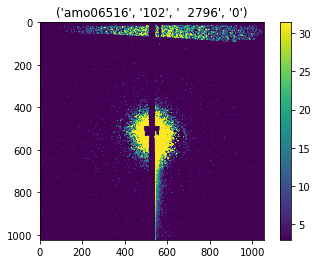

In [7]:
idx = 297
plt.figure(figsize = (6, 4))
#data = img_orig
data = data_train[idx][0]
vmin = data.mean()
vmax = vmin + 1 * data.std()
plt.imshow(data, vmin = vmin, vmax = vmax)
metadata = data_train[idx][2]
plt.title(metadata)
plt.colorbar()

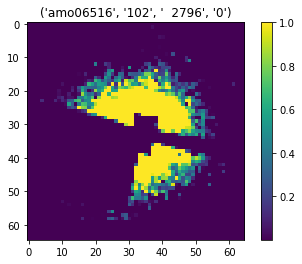

In [10]:
idx = 3
plt.figure(figsize = (6, 4))
#data = img_orig
data = dataset_train[idx][0][0]
vmin = data.mean()
vmax = vmin + 1 * data.std()
plt.imshow(data, vmin = vmin, vmax = vmax)
metadata = dataset_train[idx][2]
plt.title(metadata)
plt.colorbar()

In [ ]:
label = 0
for i in dataset_train.label_seqi_dict[label]:
    plt.figure(figsize = (6, 4))
    #data = img_orig
    data = data_train[i][0]
    vmin = data.mean()
    vmax = vmin + 1 * data.std()
    plt.imshow(data, vmin = vmin, vmax = vmax)
    metadata = data_train[i][2]
    plt.title(metadata)
    plt.colorbar()

In [ ]:
plt.figure(figsize = (15, 12))
data = img_orig
vmin = data.mean()
vmax = vmin + 1 * data.std()
plt.imshow(data, vmin = vmin, vmax = vmax)
plt.colorbar()

In [ ]:
plt.figure(figsize = (15, 12))
data = dataset_train[134][0][0]
vmin = data.mean()
vmax = vmin + 1 * data.std()
plt.imshow(data, vmin = vmin, vmax = vmax)
plt.colorbar()